## 라이브러리

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

## GPU확인

In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## RESNET모델 구현

In [4]:
from tensorflow.python.distribute.tpu_strategy import input_lib
from traitlets.config.application import KVArgParseConfigLoader
from tensorflow._api import v2

def build_resnet(input_shape, is_50):# 입력 이미지 모양, 50 : true, false
  axis = 1
  def resnet_34(x, filter_size, strides): # 34레이어 기본 구성
    x = keras.layers.Conv2D(filters = filter_size, kernel_size = (3,3), padding='same', strides =strides, kernel_initializer='he_normal')(x)
    x = keras.layers.BatchNormalization(axis)(x)
    x = keras.layers.Activation(activation= 'relu')(x)


    x = keras.layers.Conv2D(filters = filter_size, kernel_size = (3,3), padding='same', kernel_initializer='he_normal')(x)
    x = keras.layers.BatchNormalization(axis)(x)

    return x

  def resnet_50(x, filter_size, strides):# 50레이어 기본 구성
    x = keras.layers.Conv2D(filters = filter_size, kernel_size = (1,1), padding='same', strides = strides, kernel_initializer='he_normal')(x)
    x = keras.layers.BatchNormalization(axis)(x)
    x = keras.layers.Activation(activation= 'relu')(x)


    x = keras.layers.Conv2D(filters = filter_size, kernel_size = (3,3), padding='same', kernel_initializer='he_normal')(x)
    x = keras.layers.BatchNormalization(axis)(x)
    x = keras.layers.Activation(activation= 'relu')(x)

          
    x = keras.layers.Conv2D(filters = filter_size*4, kernel_size = (1,1), padding='same', kernel_initializer='he_normal')(x)
    x = keras.layers.BatchNormalization(axis)(x)
    return x

  # input
  inputs = keras.Input(shape=input_shape)

  # conv1
  x = keras.layers.Conv2D(filters = 64, kernel_size = (7,7),strides=2, activation= 'relu', padding='same')(inputs)
  x = keras.layers.BatchNormalization(axis)(x)

  x = keras.layers.MaxPool2D((2,2), strides =2)(x)

  short_cut = x # skip connection 저장

  # 레이어 정보
  layers = {'conv2':[3,64,1], 'conv3':[4,128, 2], 'conv4':[6,256,2],'conv5':[3,512,2]}

  if is_50 == False:# 50이 아니면  ==  34이면
    for v in layers.values():
      for i in range(v[0]): # 3,4,6,3
        if i ==0:
          filter_size = v[1] # 64,128,256,512 
          strides = v[2] # 1 or 2
          x = resnet_34(x, filter_size, strides)

        else:
          filter_size = v[1]# 64,128,256,512 
          strides = 1
          x = resnet_34(x, filter_size, strides)

        if short_cut.shape[1] != x.shape[1]: # 모양이 다를때
          # print(f'모양 다를때  x:{x.shape}, short_cut : {short_cut.shape}')
          short_cut = keras.layers.Conv2D(filters = x.shape[3], kernel_size = (1,1), padding='same', strides = 2, kernel_initializer='he_normal')(short_cut)
          short_cut = keras.layers.BatchNormalization(axis)(short_cut)

        elif short_cut.shape[3] != x.shape[3]: # 채널이 다를때
          # print(f'채널 다를때  x:{x.shape}, short_cut : {short_cut.shape}')
          short_cut = keras.layers.Conv2D(filters = x.shape[3], kernel_size = (1,1), padding='same', kernel_initializer='he_normal')(short_cut)
          short_cut = keras.layers.BatchNormalization(axis)(short_cut)

        x = keras.layers.Add()([x,short_cut]) 
        x = keras.layers.Activation(activation= 'relu')(x)

        short_cut = x

  else:# 50이면
    for v in layers.values():
      for i in range(v[0]):
        if i ==0:
          filter_size = v[1]
          strides = v[2]
          x = resnet_50(x, filter_size, strides)

        else:
          filter_size = v[1]
          strides = 1
          x = resnet_50(x, filter_size, strides)

        if short_cut.shape[1] != x.shape[1]: # 모양이 다를때
          # print(f'모양 다를때  x:{x.shape}, short_cut : {short_cut.shape}')
          short_cut = keras.layers.Conv2D(filters = x.shape[3], kernel_size = (1,1), padding='same', strides = 2, kernel_initializer='he_normal')(short_cut)
          short_cut = keras.layers.BatchNormalization(axis)(short_cut)

        elif short_cut.shape[3] != x.shape[3]: # 채널이 다를때
          # print(f'채널 다를때  x:{x.shape}, short_cut : {short_cut.shape}')
          short_cut = keras.layers.Conv2D(filters = x.shape[3], kernel_size = (1,1), padding='same', kernel_initializer='he_normal')(short_cut)
          short_cut = keras.layers.BatchNormalization(axis)(short_cut)

        x = keras.layers.Add()([x,short_cut]) 
        x = keras.layers.Activation(activation= 'relu')(x)
        
        short_cut = x

  x = keras.layers.AveragePooling2D(pool_size=(1,1), strides=None, padding='valid', data_format=None)(x)
  x = keras.layers.Flatten(name='flatten')(x)
  x = keras.layers.Dense(1, activation='sigmoid', name='output', kernel_initializer='he_normal')(x)

  return keras.Model(inputs=inputs, outputs=x)

## 34레이어 모델 구조 

In [5]:
resnet_34 = build_resnet(input_shape=(224,224,3), is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  448        ['conv2d[0][0]']                 
 alization)                     )                                                             

## 50레이어 모델 구조

In [6]:
resnet_50 = build_resnet(input_shape=(224,224,3), is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 112, 112, 64  448        ['conv2d_36[0][0]']              
 ormalization)                  )                                                           

## 일반 레이어 구현

In [7]:
from tensorflow.python.distribute.tpu_strategy import input_lib
from traitlets.config.application import KVArgParseConfigLoader
from tensorflow._api import v2

def plain(input_shape, is_50):
  axis = 1
  def resnet_34(x, filter_size, strides):
    x = keras.layers.Conv2D(filters = filter_size, kernel_size = (3,3), padding='same', strides =strides, kernel_initializer='he_normal')(x)
    x = keras.layers.BatchNormalization(axis)(x)
    x = keras.layers.Activation(activation= 'relu')(x)


    x = keras.layers.Conv2D(filters = filter_size, kernel_size = (3,3), padding='same', kernel_initializer='he_normal')(x)
    x = keras.layers.BatchNormalization(axis)(x)
    x = keras.layers.Activation(activation= 'relu')(x)

    return x

  def resnet_50(x, filter_size, strides):
    x = keras.layers.Conv2D(filters = filter_size, kernel_size = (1,1), padding='same', strides = strides, kernel_initializer='he_normal')(x)
    x = keras.layers.BatchNormalization(axis)(x)
    x = keras.layers.Activation(activation= 'relu')(x)


    x = keras.layers.Conv2D(filters = filter_size, kernel_size = (3,3), padding='same', kernel_initializer='he_normal')(x)
    x = keras.layers.BatchNormalization(axis)(x)
    x = keras.layers.Activation(activation= 'relu')(x)

          
    x = keras.layers.Conv2D(filters = filter_size*4, kernel_size = (1,1), padding='same', kernel_initializer='he_normal')(x)
    x = keras.layers.BatchNormalization(axis)(x)
    x = keras.layers.Activation(activation= 'relu')(x)
    return x

  # input
  inputs = keras.Input(shape=input_shape)
  # conv1
  x = keras.layers.Conv2D(filters = 64, kernel_size = (7,7),strides=2, activation= 'relu', padding='same', kernel_initializer='he_normal')(inputs)
  x = keras.layers.BatchNormalization(axis)(x)

  x = keras.layers.MaxPool2D((2,2), strides =2)(x)

  # 레이어 정보
  layers = {'conv2':[3,64,1], 'conv3':[4,128, 2], 'conv4':[6,256,2],'conv5':[3,512,2]}

  if is_50 == False:
    for v in layers.values():
      for i in range(v[0]):
        if i ==0:
          filter_size = v[1]
          strides = v[2]
          x = resnet_34(x, filter_size, strides)

        else:
          filter_size = v[1]
          strides = 1
          x = resnet_34(x, filter_size, strides)

  else:
    for v in layers.values():
      for i in range(v[0]):
        if i ==0:
          filter_size = v[1]
          strides = v[2]
          x = resnet_50(x, filter_size, strides)

        else:
          filter_size = v[1]
          strides = 1
          x = resnet_50(x, filter_size, strides)

  x = keras.layers.AveragePooling2D(pool_size=(1,1), strides=None, padding='valid', data_format=None)(x)
  x = keras.layers.Flatten(name='flatten')(x)
  x = keras.layers.Dense(1, activation='sigmoid', name='output')(x)

  return keras.Model(inputs=inputs, outputs=x)

## 50레이어 일반 모델 구조 

In [8]:
plain50 = plain(input_shape=(224,224,3), is_50=True)
plain50.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_89 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_89 (Bat  (None, 112, 112, 64)     448       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_90 (Conv2D)          (None, 56, 56, 64)        4160      
                                                                 
 batch_normalization_90 (Bat  (None, 56, 56, 64)       224 

## 모델 4가지 불러오기

In [9]:
resnet34 = build_resnet(input_shape = (224,224,3),is_50= False) 
resnet50 = build_resnet(input_shape = (224,224,3),is_50= True) 
plain34 = plain(input_shape = (224,224,3),is_50= False) 
plain50 = plain(input_shape = (224,224,3),is_50= True) 

## 데이터 불러오기

In [10]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised = True,
    )

print(ds_train, ds_info)

# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

print(ds_info.features["label"].num_classes, ds_info.features["label"].names)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteMG7OO2/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))> tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='~/tensorflow_datasets/cats_vs_dogs/4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
  

## 데이터 시긱화

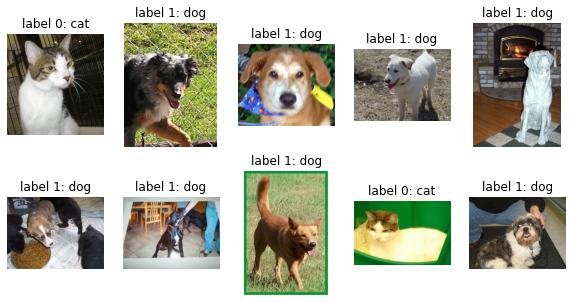

In [11]:
plt.figure(figsize=(10, 5))

get_label_name = ds_info.features['label'].int2str

for idx, (image, label) in enumerate(ds_train.take(10)):  # 10개의 데이터를 가져온다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## 데이터 정규화 및 모델에 넣을 타입으로 변환

In [12]:
def normalize_and_resize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  image = tf.image.resize(image, [224,224])
  return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
  ds = ds.map(normalize_and_resize_img)
  ds = ds.batch(batch_size)
  if not is_test:
      ds = ds.repeat()
      ds = ds.shuffle(200)
      ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

ds_train = apply_normalize_on_dataset(ds_train, batch_size=16)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=16)

In [13]:
ds_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [14]:
BATCH_SIZE =32
EPOCH = 17

## plain34 vs resnet34

In [15]:
plain34.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.001, clipnorm=1.), metrics=['accuracy'])

history_plain34 =plain34.fit(
    ds_train,
     steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/17


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 85s 111ms/step - loss: 0.6917 - accuracy: 0.5423 - val_loss: 0.6831 - val_accuracy: 0.5358
Epoch 2/17
581/581 [==============================] - 66s 113ms/step - loss: 0.6547 - accuracy: 0.6100 - val_loss: 0.6618 - val_accuracy: 0.5940
Epoch 3/17
581/581 [==============================] - 66s 113ms/step - loss: 0.6299 - accuracy: 0.6424 - val_loss: 0.6392 - val_accuracy: 0.6297
Epoch 4/17
581/581 [==============================] - 65s 113ms/step - loss: 0.6119 - accuracy: 0.6652 - val_loss: 0.6603 - val_accuracy: 0.6138
Epoch 5/17
581/581 [==============================] - 65s 113ms/step - loss: 0.5993 - accuracy: 0.6769 - val_loss: 0.5709 - val_accuracy: 0.7013
Epoch 6/17
581/581 [==============================] - 65s 113ms/step - loss: 0.5777 - accuracy: 0.6960 - val_loss: 0.5749 - val_accuracy: 0.7017
Epoch 7/17
581/581 [==============================] - 66s 113ms/step - loss: 0.5784 - accuracy: 0.6965 - val_loss: 0.5714 - val_accuracy: 0.7

In [16]:
resnet34.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.001, clipnorm=1.), metrics=['accuracy'])

history_resnet34 =resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/17
581/581 [==============================] - 78s 120ms/step - loss: 0.7000 - accuracy: 0.5602 - val_loss: 0.6384 - val_accuracy: 0.6409
Epoch 2/17
581/581 [==============================] - 69s 118ms/step - loss: 0.6482 - accuracy: 0.6280 - val_loss: 0.6212 - val_accuracy: 0.6599
Epoch 3/17
581/581 [==============================] - 69s 118ms/step - loss: 0.6325 - accuracy: 0.6429 - val_loss: 0.6758 - val_accuracy: 0.5991
Epoch 4/17
581/581 [==============================] - 68s 118ms/step - loss: 0.6056 - accuracy: 0.6743 - val_loss: 0.5725 - val_accuracy: 0.7108
Epoch 5/17
581/581 [==============================] - 69s 118ms/step - loss: 0.5990 - accuracy: 0.6732 - val_loss: 0.5616 - val_accuracy: 0.7129
Epoch 6/17
581/581 [==============================] - 68s 118ms/step - loss: 0.5795 - accuracy: 0.6914 - val_loss: 0.5574 - val_accuracy: 0.7142
Epoch 7/17
581/581 [==============================] - 69s 118ms/step - loss: 0.5635 - accuracy: 0.7064 - val_loss: 0.5549 - val_ac

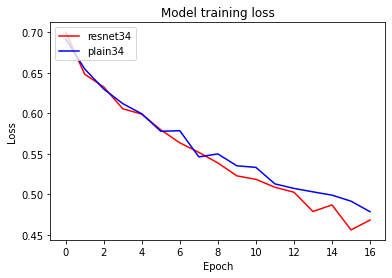

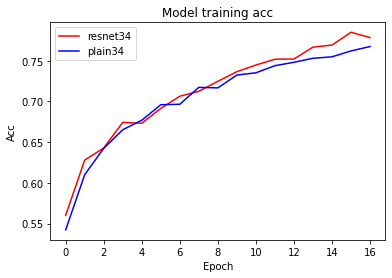

In [17]:
import matplotlib.pyplot as plt

plt.plot(history_resnet34.history['loss'], 'r')
plt.plot(history_plain34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain34'], loc='upper left')
plt.show()

plt.plot(history_resnet34.history['accuracy'], 'r')
plt.plot(history_plain34.history['accuracy'], 'b')
plt.title('Model training acc')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain34'], loc='upper left')
plt.show()

## plain 50 vs resnet 50

In [18]:
plain50.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.001, clipnorm=1.), metrics=['accuracy'])

history_plain50 =plain50.fit(
    ds_train,
     steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/17
581/581 [==============================] - 115s 181ms/step - loss: 0.6864 - accuracy: 0.5601 - val_loss: 0.7284 - val_accuracy: 0.5030
Epoch 2/17
581/581 [==============================] - 105s 180ms/step - loss: 0.6698 - accuracy: 0.5885 - val_loss: 0.6393 - val_accuracy: 0.6310
Epoch 3/17
581/581 [==============================] - 104s 179ms/step - loss: 0.6572 - accuracy: 0.6130 - val_loss: 0.6807 - val_accuracy: 0.5996
Epoch 4/17
581/581 [==============================] - 104s 179ms/step - loss: 0.6455 - accuracy: 0.6239 - val_loss: 0.6333 - val_accuracy: 0.6332
Epoch 5/17
581/581 [==============================] - 104s 179ms/step - loss: 0.6354 - accuracy: 0.6354 - val_loss: 0.6146 - val_accuracy: 0.6625
Epoch 6/17
581/581 [==============================] - 104s 179ms/step - loss: 0.6233 - accuracy: 0.6529 - val_loss: 0.5810 - val_accuracy: 0.6931
Epoch 7/17
581/581 [==============================] - 104s 179ms/step - loss: 0.6148 - accuracy: 0.6592 - val_loss: 0.6310 -

In [19]:
resnet50.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.001, clipnorm=1.), metrics=['accuracy'])

history_resnet50 =resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/17
581/581 [==============================] - 135s 213ms/step - loss: 0.7078 - accuracy: 0.5645 - val_loss: 0.6647 - val_accuracy: 0.6030
Epoch 2/17
581/581 [==============================] - 122s 211ms/step - loss: 0.6638 - accuracy: 0.6072 - val_loss: 0.6075 - val_accuracy: 0.6780
Epoch 3/17
581/581 [==============================] - 123s 211ms/step - loss: 0.6435 - accuracy: 0.6356 - val_loss: 0.6147 - val_accuracy: 0.6552
Epoch 4/17
581/581 [==============================] - 123s 211ms/step - loss: 0.6229 - accuracy: 0.6560 - val_loss: 0.5820 - val_accuracy: 0.6961
Epoch 5/17
581/581 [==============================] - 123s 211ms/step - loss: 0.6111 - accuracy: 0.6646 - val_loss: 0.6698 - val_accuracy: 0.6086
Epoch 6/17
581/581 [==============================] - 123s 211ms/step - loss: 0.5932 - accuracy: 0.6821 - val_loss: 0.5558 - val_accuracy: 0.7172
Epoch 7/17
581/581 [==============================] - 123s 211ms/step - loss: 0.5790 - accuracy: 0.6941 - val_loss: 0.7576 -

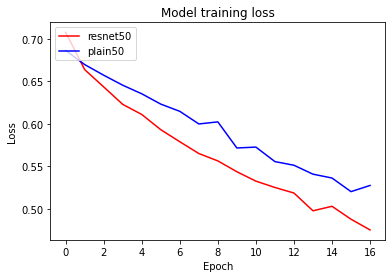

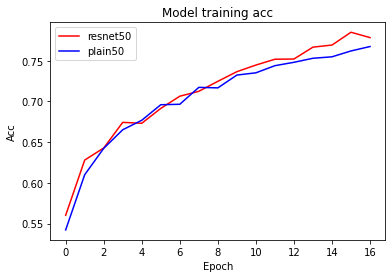

In [20]:
import matplotlib.pyplot as plt

plt.plot(history_resnet50.history['loss'], 'r')
plt.plot(history_plain50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain50'], loc='upper left')
plt.show()


plt.plot(history_resnet34.history['accuracy'], 'r')
plt.plot(history_plain34.history['accuracy'], 'b')
plt.title('Model training acc')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain50'], loc='upper left')
plt.show()

## 회고
- 모델 구성 완.벽
- loss 완.벽
- val_acc를  통한 Ablation Study 결과표
  - resnet34: 0.7125
  - plain34:0.7565
  - resner50:0.7302
  - plain50:0.7284

-  기본적으로 모델만 완벽하다면 그 외의 부분들은 어떻게 되든 결과는 내가 원하는 대로 resnet의 성능이 좋게 나와야 했다. 하지만 계속해서 loss가 제대로 안찍혀서 여러가지 시도를 해봤고 결국에 모델의 구성에서 커널 초기화(가중치를 초기화 해주는것 같음)를 'he_normal'로 바꾸면서 결과가 제대로 뜨기 시작했다.

- 여러가지 시도들

  1. 하이퍼 파라미터 : 모델만 잘  쌓았으면 이부분이 어떻게 되든 사실 결과는 원하는 대고 나오야 했지만 그래도 일단 4가지의 경우에 대해 시도를 해 보았다.
    - 1. 배치를 크게 lr은 작게
    - 2. 배치를 작게 lr은 크게
    - 3. 배치를 작게 lr도 작게
    - 4. 배치를 크게 lr도 크게
    - 결론적으로 이과정은 역시나 아무런 도움이 되지 않았다.

  2. 마지막 dense 레이어의 활성화 함수는 relu가 아니라 softmax였다. 
    - 난 relu면 다 좋은건줄... 

  3. 손실함수 변경 sparse_categorical_crossentropy -> binary_crossentropy로 변경
    - 이과정에서 dense의 출력과 활성화 함수도 변경 (1,sigmoid)

  - 위 의 과정들로도 원하는 결과는 찾을 수 없었다.

  4. 커널사이즈 변경 : 기본적으로 커널사이즈의 형식은 'glorot_uniform'로 되있는것 같았고 이것을 'he_normal로 변경하였더니 원하는 결과값이 나왔다. 
    - 아직까지 이과정이 의미 하는게 뭔지는 모르지만 차차 알아가보고 이번 노드에서는 모델을 쌓아 봤다는것에 의의를 두려고 한다.